### Machine Learning pentru Aplicatii Vizuale
# Laborator 5: Retele Generative

## 1. Introducere

In laboratoarele anterioare, scopul retelelor neuronale antrenate a fost de a estima probabilitatea $P(y|x), y \in C$, unde $y$ este o eticheta din totalitatea claselor $C$, iar $x \in X$ este imaginea curenta (cunoscuta). Din acest motiv, aceasta clasa de arhitecturi sunt denumite <b>modele discriminative</b>. In contrast cu acestea, <b>modelele generative</b> incearca sa determine un posibil $x$ apartinand uneia dintre clasele $y$ sau, mai exact, in cazul aplicatiilor vizuale, pixelii unei imagini. Plecand de la un set de date oarecare, se doreste obtinerea unor esantioane noi, care ar putea face parte din acel set. De exemplu, pentru baza de date MNIST, generatorul poate incerca sa sintetizeze imagini noi cu fiecarea cifra, cum ar fi "5".

Desi modelele generative nu sunt o noutate in <i>Machine Learning</i>, acestea au prins un avant substantial odata cu aparitia unor solutii moderne performante, precum VAE (<i>Variational Autoencoders</i>) si <b>GAN</b>. In continuare, vor fi explorate ultimele, in implementarea lor bazata pe CNN-uri. Plecand de la setul de date <b>MNIST</b>, folosit anterior in sarcina tipica de clasificare, va fi prezentata arhitectura generala a unui GAN si diferentele fata de modul de antrenare a retelelor anterioare.

## 2. Retele Generative Adversariale

### 2.1. Principii fundamentale

Modelele bazate pe Retele Generative Adversariale (<i>Generative Adversarial Nets</i> - GAN) se disting pe utilizarea simultana a doua arhitecturi neuronale: una denumita generator (<b>G</b>) si un discriminator (<b>D</b>). Aceste doua arhitecturi se afla in opozitie una fata de cealalta pe parcursul procesului de antrenare, performanta fiecareia bazandu-se pe evolutia celeilalte. Reteaua D trebuie sa clasifice un esantion din setul de date de antrenare ca fiind real iar unul generat de G ca fiind fals. In acelasi timp G incearca sa creeze esantioane noi cat mai credibile, care sa fie clasificate de D ca fiind reale. 

Daca pentru arhitectura D intrarea se poate deduce ca este de forma datelor reale (ex.: imagini), pentru generator, lucrurile nu mai sunt atat de clare. Punctul de start pentru acesta este un vector de valori aleatoare esantionate dintr-o distributie aleasa, denumit vector latent (sau un <i>zgomot</i>) $z$. Tinand cont de modul in care functioneaza algoritmul, nu exista informatii despre cum influenteaza valorile din vectorul $z$ iesirea lui G.

Formal, din punct de vedere al procesului de optimizare, loss-ul a fost definit in lucrarea originala (\[1\]) ca:
$$\underset{G}{min}\underset{D}{max}L(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[logD(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1-D(G(z)))]$$

Desi loss-ul de mai sus este intuitiv, fiind o combinatie de costuri de tipul Entropie Incrucisata Binara (<i>Binary Cross Entropy</i>), in practica antrenarea unei retele GAN de acest fel este un proces sensibil la diverse variatii aleatoare, predispus la instabilitate. Daca in varianta originala s-au folosit MLP-uri pentru retelele D si G, procesul de generare folosind retele convolutionale a fost descris in \[2\], iar alte costuri precum cel Wasserstein (\[3\]) au adus imbunatatiri substantiale stabilitatii si calitatii rezultatelor finale. Cu toate acestea, pentru a nu complica lucrurile, in partea practica a acestei lucrari de laborator se vor folosi arhitecturi convolutionale antrenate cu o functie loss similara celei de mai sus.

Particularizand pentru aplicatiile vizuale, scopul unui GAN este de a genera imagini noi, care sa fie similare din punct de vedere vizual cu un set de imagini naturale (reale). Pentru a ilustra acest fapt, s-a urmarit evolutia retelei G la intrarea careia s-a aplicat acelasi vector $z$ pe parcursul procesului de antrenare. La fiecare 100 de iteratii, imaginea obtinuta a fost comparata cu toate esantioanele din setul de antrenare MNIST, folosind o metrica de similaritate structurala (<i>Structural Similarity Index Measure</i> - SSIM). In graficul de mai jos este afisata valoarea medie a SSIM pe parcursul a 1800 de iteratii. Se poate observa ca dupa o perioada initiala instabila, imaginea generata a inceput sa fie asemanatoare cu cele folosite la antrenare.

<center><img src="media/comp_ssim.png" width="500"></center>
<center>Evolutia SSIM pe parcursul unei antrenari. La fiecare 100 de iteratii a fost calculata valoarea medie a SSIM,<br> comparand rezultatul lui G pentru acelasi vector de intrare $z$ cu imaginile de antrenare din MNIST. </center><br><br>


### 2.2. Reteaua discriminatoare (D)

Reteaua D care va fi folosita in aceasta lucrare este similara conceptual celei folosite in laboratoarele anterioare. Plecand de la o imagine 28 x 28 pixeli cu un singur canal de culoare, reteaua trece prin mai multe straturi de tip ```nn.Conv2D``` iar iesirea consta intr-un strat ```nn.Linear```. De aceasta data, insa, in loc de zece neuroni de iesire (corespunzatori celor 10 cifre), reteaua va avea doar 2 valori, deoarece problema de clasificare se transforma din <i>care din cele zece cifre este prezenta in imagine</i>, in <i>este reala sau generata imaginea</i>. Din aceasta schimbare a problemei, se poate deduce faptul ca nu conteaza care din cifre este generata, ci daca este suficient de convigatoare noua imagine.

Alte diferente importante fata de arhitecturile anterioare este lipsa straturilor de tip ```nn.MaxPool2d``` si folosirea altei functii de activare. Pentru a reduce numarul de linii si coloane ale hartilor de activare, se vor folosi convolutii cu pas (<i>stride</i>) mai mare de 1. Din perspectiva functiei de activare, in loc de ReLU se va folosi <i>Leaky ReLU</i>. Aceasta va permite si valori negative, insa atenuate cu un factor constant, care trebuie specificat: $$ LeakyReLU(x) = \begin{cases} x, & x >= 0\\ atenuare * x, & x < 0 \end{cases}$$

<center><img src="media/leaky_relu.png" width="500"></center>
<center>Functia de activare Leaky ReLU, atunci cand factorul de atenuare este setat la 0.05</center><br><br>

Modificarile fata de arhitecturile anterioare au fost facute pe baza recomandarilor din \[2\], pentru a asigura o stabilitate mai buna a procesului de antrenare al ansamblului. Clasa arhitecturii de tip discrimnator este deci:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm


# Discriminator code
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Intrare imagine reala - nr_imag x 1 x 128 x 128
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False,
        )
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)

        # nr_imag x 16 x 14 x 14
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(32)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)

        # nr_imag x 32 x 7 x 7
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(64)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)

        # nr_imag x 64 x 4 x 4
        self.conv4 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn4 = nn.BatchNorm2d(128)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)

        # nr_imag x 128 x 1 x 1
        self.out = nn.Linear(in_features=128, out_features=2)

    def forward(self, input):
        x = self.conv1(input)
        x = self.lrelu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.lrelu4(x)

        x = torch.flatten(x, 1, 3)
        x = self.out(x)

        return x

(pentru simplitate, au fost adaugate si toate bibliotecile utilizate in restul codului)

### 2.3. Reteaua generatoare

Spre deosebire de arhitectura de mai sus, reteaua G are un comportament vizibil diferit. Pana acum, s-a plecat de la o imagine, iar reprezentarile intermediare au avut o rezolutie din ce in ce mai mica. In acest caz, insa, intrarea este un vector, dar rezolutia reprezentarii va creste pe parcursul propagarii inainte, rezultand o imagine. Acest lucru este realizat cu ajutorul unei noi operatii, denumita <i>convolutie transpusa</i> (intalnita uneori, in mod eronat, ca deconvolutie). Cel mai simplu mod de a urmari schimbarea dimensionalitatii este de a inversa intrarea si iesirea din strat. Daca pe matricea $X$ se aplica o convolutie cu un nucleu de dimensiune $k$, pas $p$, etc. se obtine iesirea $Y$, a carei dimensiuni se pot calcula. In cazul convolutiei transpuse, avand aceiasi parametri $k$, $p$, etc., se pune intrebarea "ce dimensiune ar trebui sa aiba $Y$, astfel incat sa se obtina o harta de activare de dimensiunea $X$, daca s-ar aplica convolutia pe $Y$?".

Din aceasta modalitate inversa de a urmari dimensionalitatea matricilor, variabilele pe care le-am discutat in cadrul convolutiilor ajung sa aiba un efect opus fata de cel obisnuit. Adaugarea bordarii va conduce la o iesire mai mica, iar cresterea pasului va duce la o matrice de iesire mai mare. In figura de mai jos se pot urmari cateva exemple ale acestui comportament. Pentru o prezentare in detaliu a acestui tip de strat, este recomandata citirea referintei \[4\].

<center>
<video align="center" width="344" height="386" controls><source src="media/[proc]conv_transp_no_pad_no_stride.mp4" type="video/mp4"></video>
<video align="center" width="344" height="386" controls><source src="media/conv_transp_same_pad_no_stride.mp4" type="video/mp4"></video>
</center>
<center>(stanga) Convolutie transpusa fara bordare si pas unitar<br>
(dreapta) Convolutie transpusa cu bordare si pas unitar<br>
Animatii preluate din <a href="https://github.com/vdumoulin/conv_arithmetic">aceasta resursa</a></center>

Pentru a defini un strat de convolutie transpusa, se utilizeaza urmatoarea sintaxa:

```tconv_x = nn.ConvTranspose2d(in_channels = nr_canale_input, out_channels = nr_canale_output, kernel_size = dim_filtru, stride = pas, padding = dim_bordare, output_padding = dim_bordare_iesire, dilation=dilatare)```

Pentru a calcula rapid dimensiunea iesirii din acest strat se foloseste urmatoarea formula, din documentatia oficiala <a href="https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html">PyTorch</a> (cu o varianta echivalenta si pentru latime):

$$H_{out} = (H_{in}-1) * pas - 2 * dim\_bordare + dilatare * (dim\_filtru-1) + dim\_bordare\_iesire + 1$$

In mod obisnuit, nu se aplicau functii de activare pe iesirea din retea, deoarece functia de cost ```nn.CrossEntropyLoss``` aplica implicit o activare Softmax. Acum insa, se doreste ca valorile de iesire din retea sa fie dintr-un interval inchis adecvat pentru lucrul cu imagini. Din acest motiv reteaua G are drept ultim strat o activare de tip Sigmoid, care restrange intervalul de valori la $(0, 1)$.

<b>!Atentie</b>: Trebuie reamintit ca, desi imaginile au cel mai des valori intregi in intervalul $[0,255]$, atunci cand se lucreaza cu valori reale, multe biblioteci necesita ca intervalul sa fie $[0,1]$, fapt ce justifica suplimentar alegerea activarii sigmoide.

Clasa arhitecturii generatoare este in acest caz:

In [2]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, dim_zg):
        super(Generator, self).__init__()

        # Intrare vector latent - nr_imag x 100 x 1 x 1
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=dim_zg,
            out_channels=128,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU(True)

        # nr_imag x 128 x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(True)

        # nr_imag x 64 x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU(True)

        # nr_imag x 32 x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=3,
            bias=False,
        )

        # nr_imag x 1 x 28 x 28
        self.out = nn.Sigmoid()

    def forward(self, input):
        x = self.tconv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.tconv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.tconv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.tconv4(x)

        return self.out(x)

### 2.4. Schimbari ale clasei Dataset

Clasa derivata din ```Dataset``` are in mare parte aceeasi structura cu varianta folosita in laboratoarele anterioare. Totusi, deoarece discriminatorul este interesat doar distinctia dintre imagini <b>reale</b> si imagini <b>generate</b>, nu mai este nevoie sa fie incarcate etichetele din setul de date MNIST. De asemenea, valorile pixelilor imaginilor sunt impartite la $255$, reducand intervalul de valori la $[0,1]$. Aceasta alegere poate fi explicata o data de faptul ca si imaginile generate se afla in acest interval, dar si de faptul ca, in general, aceasta plaja de valori asigura o performanta mai mare a retelei D. Clasa devine astfel:

In [3]:
class DatasetMNIST_GAN(Dataset):
    def __init__(self, cale_catre_date, cale_catre_etichete):
        f_img = open(cale_catre_date, "r", encoding="latin-1")
        f_lbl = open(cale_catre_etichete, "r", encoding="latin-1")

        f_img.read(
            16
        )  # 4 bytes magic number, 4 bytes nr imag, 4 bytes nr linii, 4 bytes nr coloane
        f_lbl.read(8)  # 4 bytes magic number, 4 bytes nr labels

        mnist_data = np.fromfile(f_img, dtype=np.uint8).reshape(-1, 1, 28, 28)
        mnist_labels = np.fromfile(f_lbl, dtype=np.uint8)

        # Filtrare doar cifrele '7'
        mask = mnist_labels % 2 == 0
        mnist_data = mnist_data[mask]

        # Conversii pentru a se potrivi cu procesul de antrenare
        self.mnist_data = mnist_data.astype(np.float32) / 255

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        return self.mnist_data[idx]

## 3. Antrenarea unui GAN

Dupa definirea retelelor si a clasei derivate din ```Dataset```, acestea se pot instantia si sa fie scrisa bucla principala de antrenare. In cazul fiecarei iteratii de antrenare se vor distinge doua zone distincte:
- antrenarea discriminatorului D, unde
  - sunt propagate prin D imaginile reale din batch-ul curent
  - se genereaza vectorii de intrare in G ca ```torch.randn(len(data), dim_zg, 1, 1)``` (se observa ca trebuie pastrata structura de matrice 4D pentru stratul de convolutie transpusa)
  - se genereaza imagini plecand de la vectorii de mai sus
  - sunt propagate imaginile generate de G prin D, atasandu-le eticheta de imagini generate (false - 0)
  - se actualizeaza ponderile lui D
- antrenarea generatorului G, unde
  - aceleasi imagini generate de G sunt propagate prin D, de data aceasta atasandu-le eticheta de imagini reale (1)
  - se actualizeaza ponderile lui G, in functie de cat de bine a "pacalit" pe D; un valoare mica a loss-ului inseamna ca discriminatorul a considerat multe din imagini ca fiind reale
  
Pe langa aceasta schimbare importanta in modul de antrenare, se va mai observa un set de vectori denumiti ```esantioane_proba```, care sunt propagati prin G la sfarsitul fiecarei epoci. Desi nu are vreun rol in antrenarea arhitecturii, in acest mod se poate urmari evolutia ei de-a lungul iteratiilor.

Deoarece epocile ar trebui sa dureze mai mult in aceasta antrenare, a fost utilizata biblioteca ```tqdm``` pentru a urmari evolutia iteratiilor. Pentru instalare este suficienta rularea comenzii ```pip install tqdm``` din linia de comanda.

Codul de antrenare este deci:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 461/461 [00:05<00:00, 79.70it/s]


Epoca 1 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 92.16it/s]


Epoca 2 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 84.56it/s]


Epoca 3 a fost incheiata


100%|██████████| 461/461 [00:06<00:00, 76.30it/s]


Epoca 4 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 84.34it/s]


Epoca 5 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 87.78it/s]


Epoca 6 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 84.91it/s]


Epoca 7 a fost incheiata


100%|██████████| 461/461 [00:06<00:00, 76.41it/s]


Epoca 8 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 88.91it/s]


Epoca 9 a fost incheiata


100%|██████████| 461/461 [00:05<00:00, 83.48it/s]


Epoca 10 a fost incheiata


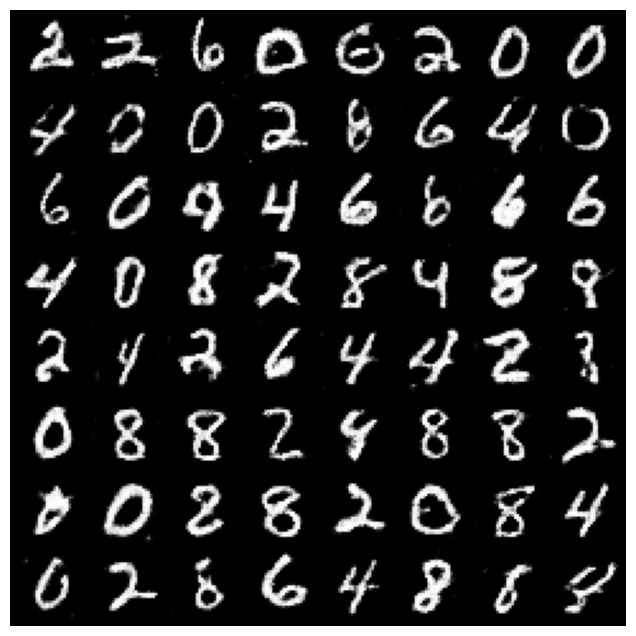

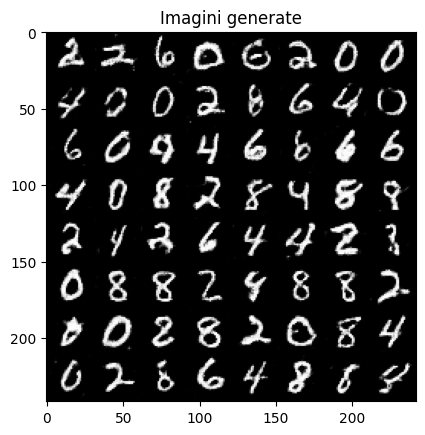

In [5]:
# Setare seed pentru reproductibilitatea experimentului
seed = 999
random.seed(seed)
torch.manual_seed(seed)

# Batch size during training
batch_size = 64

# Number of training epochs
nr_epoci = 10

# Initializare set de date si dataloader
dataset = DatasetMNIST_GAN(r"train-images.idx3-ubyte", r"train-labels.idx1-ubyte")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Dimensiunea vectorului latent (zgomotul folosit la generare)
dim_zg = 100
# Initializare retele
retea_g = Generator(dim_zg).to(device)
retea_d = Discriminator().to(device)

# Functia loss
loss_function = nn.CrossEntropyLoss()

# Esantioane din care se vor genera imagini, pentru a vizualiza imbunatatirea retelei pe parcursul antrenarii
esantioane_proba = torch.randn(64, dim_zg, 1, 1).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(retea_d.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(retea_g.parameters(), lr=2e-4, betas=(0.5, 0.999))


# Lista de imagini obtinute din esantioane_proba
img_list = []

# Bucla principala de antrenare
# Imaginile reale au eticheta 1
# Imaginile false au eticheta 0
for ep in range(nr_epoci):
    for data in tqdm(dataloader):
        # Antrenarea retelei discriminatoare -> se doreste ca reteaua aceasta sa identifice esantioanele
        # generate ca fiind false si pe cele din setul de date ca fiind reale

        # Imagini reale
        retea_d.zero_grad()

        # Eticheta reala este 1
        # Se genereaza un vector de intregi de valoare 1
        label = torch.LongTensor(np.ones(len(data))).to(device)
        output = retea_d(data.to(device))
        loss_imagini_reale = loss_function(output, label.long())
        loss_imagini_reale.backward()

        # Imagini generate
        # Generare vector latent
        vector_generare = torch.randn(len(data), dim_zg, 1, 1)
        # Generare imagini din vectorul latent
        imagini_generate = retea_g(vector_generare.to(device))
        # Eticheta imaginilor generate este 0
        label = torch.LongTensor(np.zeros(len(data))).to(device)
        # Clasificare imaginilor generate
        # Nu se doreste ajustarea ponderilor generatorului acum, motiv pentru
        # care se foloseste metoda detach care asigura ca nu se vor calcula
        # gradientii pentru G
        output = retea_d(imagini_generate.detach())
        loss_imagini_generate = loss_function(output, label.long())
        loss_imagini_generate.backward()

        # Ajustarea ponderilor discriminatorului
        optimizerD.step()

        # Antrenarea retelei generatoare -> se doreste ca reteaua discriminatoare sa identifice esantioanele
        # generate ca fiind reale

        retea_g.zero_grad()
        # Pentru a antrena generatorul, reteaua discriminatoare trebuie sa vada imaginile generate ca fiind reale
        label = torch.LongTensor(np.ones(len(data))).to(device)
        output = retea_d(imagini_generate.to(device))
        loss_imagini_generate = loss_function(output, label.long())
        loss_imagini_generate.backward()
        # Ajustarea ponderilor generatorului
        optimizerG.step()

    with torch.no_grad():
        imagini_generate = retea_g(esantioane_proba).to("cpu").detach()
    img_list.append(vutils.make_grid(imagini_generate, padding=2, normalize=True))

    print("Epoca {} a fost incheiata".format(ep + 1))


fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Afisarea ultimelor imagini de proba generate
plt.figure()
plt.title("Imagini generate")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

<b>!Atentie</b>: in mod normal, pachetul IPython ar trebui sa fie instalat, daca ati lucrat anterior cu Jupyter Notebook. Daca acesta lipseste, totusi, se poate instala cu ajutorul pip - ```pip install ipython```

### Exercitiu: Antrenati o arhitectura GAN care sa genereze cifre, folosind setul MNIST ca sursa de date reale.

### Exercitiu: Modificati codul din exercitiul anterior, pentru a genera doar cifra 7.

Bibliografie
1. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. Advances in neural information processing systems, 27.
2. Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.
3. Arjovsky, M., Chintala, S., & Bottou, L. (2017, July). Wasserstein generative adversarial networks. In International conference on machine learning (pp. 214-223). PMLR.
4. Dumoulin, V., & Visin, F. (2016). A guide to convolution arithmetic for deep learning. arXiv preprint arXiv:1603.07285.